## Airbnb project

In [468]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import seaborn as sns
import numpy as np
import shapely
from geopy import distance

In [469]:
pd.options.mode.chained_assignment = None

In [470]:
#hood = gpd.read_file('neighbourhoods.geojson')
metro = gpd.read_file('metro.geojson')
df = pd.read_csv('listings.csv')

C:\Users\raffa\anaconda3\lib\site-packages\geopandas\geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


# Metro dataset

In [471]:
df2 = metro.copy()
for i in range(len(df2)):
    if not '/' in df2['LINHA'][i]:
        df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [472]:
for i in range(len(metro)):
    if '/' in  metro['LINHA'][i]:
        metro['LINHA'][i] = metro['LINHA'][i].split('/')[0]

for j in range(len(df2)):
    df2['LINHA'][j] = df2['LINHA'][j].split('/')[1]
    
metro = pd.concat([metro, df2])

In [473]:
metro = pd.concat([metro, df2])
metro = metro.drop(columns = ['index','OBJECTID','COD_SIG','IDTIPO','SITUACAO','GlobalID'])

In [474]:
metro

,NOME,LINHA,geometry
0,Cais do Sodré,Verde,POINT (-9.14609 38.70627)
1,Terreiro do Paço,Azul,POINT (-9.13419 38.70728)
2,Baixa Chiado,Azul,POINT (-9.14015 38.71057)
3,Santa Apolónia,Azul,POINT (-9.12241 38.71404)
4,Rossio,Verde,POINT (-9.13792 38.71418)
...,...,...,...
1,Marquês de Pombal,Amarela,POINT (-9.15005 38.72532)
2,São Sebastião,Vermelha,POINT (-9.15394 38.73453)
3,Saldanha,Vermelha,POINT (-9.14533 38.73532)
4,Alameda,Vermelha,POINT (-9.13387 38.73697)


In [475]:
yellow = metro[metro.LINHA == 'Amarela'].reset_index()
blue = metro[metro.LINHA == 'Azul'].reset_index()
green = metro[metro.LINHA == 'Verde'].reset_index()
red = metro[metro.LINHA == 'Vermelha'].reset_index()

# Metro Network

In [476]:
import networkx as nx
from pyvis.network import Network

Import the graph baseline from excel where we have column for Origin and Destination

In [477]:
metro_graph = pd.read_excel('metro.xlsx')

In [478]:
metro_graph = metro_graph.dropna()
metro_graph = metro_graph.drop(columns = ['NOME', 'LINHA', 'Unnamed: 0', 'OBJECTID'])

## Set up the graph

In [479]:
G = nx.Graph()
G = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination')

In [480]:
net = Network(notebook=True)
net.from_nx(G)
net.width=500
net.height=500
net.show('metro.html')

Get the origin and destination coordinates

In [481]:
metro_dict = dict(zip(metro.NOME, metro.geometry))
metro_graph['p1'] = (metro_graph['Origin']).map(metro_dict)
metro_graph['p2'] = (metro_graph['Destination']).map(metro_dict)

C:\Users\raffa\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Create a LineString object between origin and Destination

In [482]:
a = []
for i in range(len(metro_graph)):
    a.append((LineString([metro_graph.p1[i],metro_graph.p2[i]])))

metro_graph['LineString'] = a

Transform the graph in a Geopandas Datframe

In [483]:
metro_graph = gpd.GeoDataFrame(metro_graph)

## Calculate distance between nodes

In [484]:
from shapely.geometry import LineString
from shapely.ops import transform
from functools import partial
import pyproj

This function transforms the LineString distance in Meters

In [485]:
def transform_linestring(df):
    
    lenghts = []
    project = partial(pyproj.transform, pyproj.Proj('EPSG:4326'), pyproj.Proj('EPSG:32633'))
    for line in df.LineString:
        lenghts.append(int(transform(project, line).length))
    
    df['distance_meters'] = lenghts

In [486]:
transform_linestring(metro_graph)

We now have a graph with a distance attribute to calculate degree importance based on.

In [487]:
G_distance = nx.from_pandas_edgelist(metro_graph, 'Origin', 'Destination',['distance_meters'])

### Degrees

In [555]:
#degree_sort = sorted(G_distance.degree(), key=lambda x: x[1], reverse=True)
degrees = {node:val for (node, val) in G_distance.degree()}

closeness = nx.closeness_centrality(G_distance, distance='distance_meters')

between = nx.betweenness_centrality(G_distance, weight='distance_meters')

eigen = nx.eigenvector_centrality(G_distance,max_iter=10000, weight='distance_meters')

centrality = nx.degree_centrality(G_distance)

In [556]:
betweness = pd.DataFrame.from_dict(between, orient='index').rename(columns = {0: 'Betweness'}).reset_index().rename(columns = {'index': 'station'})
closeness = pd.DataFrame.from_dict(closeness, orient='index').rename(columns = {0: 'Closeness'}).reset_index().rename(columns = {'index': 'station'})
eigeness = pd.DataFrame.from_dict(eigen, orient='index').rename(columns = {0: 'Eigeness'}).reset_index().rename(columns = {'index': 'station'})
central = pd.DataFrame.from_dict(centrality, orient='index').rename(columns = {0: 'Centrality'}).reset_index().rename(columns = {'index': 'station'})
Degree = pd.DataFrame.from_dict(degrees, orient='index').rename(columns = {0: 'Degree'}).reset_index().rename(columns = {'index': 'station'})
weight = pd.merge(betweness, closeness, on='station')
weight = pd.merge(weight, eigeness, on='station')
weight = pd.merge(weight, central, on='station')
weight = pd.merge(weight, Degree, on='station')

## assinging a specific wight to each metro station based on it's Degree (#of connections) and Eigenvector Centrality value, and Betweness value

In [557]:
weight['grade']=weight['Degree'] + weight['Eigeness']*5 + weight['Betweness']*5
# the values of the Eigenvector and Betwennes variables are multiplied by a factor of 5 in order to give them a higher relevance, 
#their importance would infact otherwise be obscured by the Degree variable which is by it own nature of a higher order of magnitude.

In [491]:
metro['station grade']=weight['grade']

In [492]:
weight['degree_mean'] = weight.iloc[:,1:4].mean(axis=1)

In [493]:
lines_dict = dict(zip(metro.NOME, metro.LINHA))
station_coord = dict(zip(metro.NOME, metro.geometry))

weight['line_color'] = (weight['station']).map(lines_dict)
weight['Coordinate'] = (weight['station']).map(station_coord)

C:\Users\raffa\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Function that gives the distance in meters from a specified point to each metro station

## Deleting columns in excess

In [496]:
weight = weight.drop(columns = weight.iloc[:,9:-1].columns.tolist())
weight = weight.drop(columns = weight.iloc[:,1:4].columns.tolist())


In [497]:
weight

,station,Centrality,Degree,grade,degree_mean,line_color,Coordinate
0,Reboleira,0.020408,1,1.000073,0.000030,Azul,POINT (-9.22388329557507 38.752271287954)
1,Amadora Este,0.040816,2,2.204270,0.013646,Azul,POINT (-9.21790161711738 38.758715859802)
2,Alfornelos,0.040816,2,2.399926,0.026693,Azul,POINT (-9.20447747827746 38.7605071115253)
3,Pontinha,0.040816,2,2.587180,0.039180,Azul,POINT (-9.19693737461709 38.7623917163549)
4,Carnide,0.040816,2,2.766813,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562)
5,Colégio Militar,0.040816,2,2.940632,0.062748,Azul,POINT (-9.18982582843268 38.7538737032722)
6,Alto dos Moinhos,0.040816,2,3.107899,0.073904,Azul,POINT (-9.18055368307301 38.7501358045407)
7,Laranjeiras,0.040816,2,3.273744,0.084964,Azul,POINT (-9.17248892825242 38.7486544474615)
8,Jardim Zoológico,0.040816,2,3.447886,0.096579,Azul,POINT (-9.16832747191897 38.7413650553712)
9,Praça de Espanha,0.040816,2,3.634675,0.109039,Azul,POINT (-9.15932888063129 38.7378628556453)


In [500]:
weight

,station,Centrality,Degree,grade,degree_mean,line_color,Coordinate
0,Reboleira,0.020408,1,1.000073,0.000030,Azul,POINT (-9.22388329557507 38.752271287954)
1,Amadora Este,0.040816,2,2.204270,0.013646,Azul,POINT (-9.21790161711738 38.758715859802)
2,Alfornelos,0.040816,2,2.399926,0.026693,Azul,POINT (-9.20447747827746 38.7605071115253)
3,Pontinha,0.040816,2,2.587180,0.039180,Azul,POINT (-9.19693737461709 38.7623917163549)
4,Carnide,0.040816,2,2.766813,0.051157,Azul,POINT (-9.19273248473962 38.7591726199562)
5,Colégio Militar,0.040816,2,2.940632,0.062748,Azul,POINT (-9.18982582843268 38.7538737032722)
6,Alto dos Moinhos,0.040816,2,3.107899,0.073904,Azul,POINT (-9.18055368307301 38.7501358045407)
7,Laranjeiras,0.040816,2,3.273744,0.084964,Azul,POINT (-9.17248892825242 38.7486544474615)
8,Jardim Zoológico,0.040816,2,3.447886,0.096579,Azul,POINT (-9.16832747191897 38.7413650553712)
9,Praça de Espanha,0.040816,2,3.634675,0.109039,Azul,POINT (-9.15932888063129 38.7378628556453)


# Correlation analysis between house price and distance from relevant areas of the city
here we want to check if house prices is also affected by their location within the city If we find any sort of correlation, we'll be able to strip this price component from the price itself, so that the following correlation analysis with the distance from the closest metro station will be more accurate, because it won't take into account the component of the price that varies due to a different factor.

In [501]:
#list of monuments and areas that were considered potentially relevant for the variation of hous prices
list_of_monuments_2= {'Elevador de Santa Justa': ((-9.139221, 38.712173), 1),
                    'Praça do Comércio': ((-9.136744, 38.707779), 1),
                     'Marques d Pobal' : ((-9.149809571870293, 38.72520372326393 ),1),
                     'Praca dom luois I' : (( -9.14651051085467, 38.70696585893371),1),
                     'Jardim Guerra Junqueiro (Jardim da Estrela)' : ((-9.157568180154488, 38.715165895486756),1),
                     'Miradouro de São Pedro de Alcântara' : ((-9.144383380607636, 38.714999758691214 ), 1),
                     'Assembly of the Republic' : (( -9.154170376301336, 38.71222285831986),1)
                     }

## the cell below is the one in which to insert the final reducted dataframe

In [502]:
#sorting dataset based on houses average distances from points of interest
#slicing dataset based on house type
#excluding from the analysis houses with a price higher than 150€ per night.

df_red=df[df['price']<150]
df_red_apt=df_red[df_red['room_type']=='Entire home/apt']
df_red_rooms=df_red[df_red['room_type']=='Private room']
df_red_hotel=df_red[df_red['room_type']=='Hotel room']
df_red_shared=df_red[df_red['room_type']=='Shared room']

In [503]:
import geopy

#computing average distance between a given house and every given point of interest

def house_avg_distance(monuments, houses,j):  
    tot_dist=0
    for i in range(len(monuments)):
        coord_1=(list(monuments.values())[i][0][1],list(monuments.values())[i][0][0])
        coord_2=(houses.latitude[j],houses.longitude[j])
        distance=geopy.distance.distance(coord_1, coord_2).km
        tot_dist=tot_dist+distance
    avg_dst=(tot_dist/len(monuments))*10
    
    return(avg_dst)   
    
    

In [504]:
#computing average distance form points of interest for each house in the dataset
def distances(houses, monuments):
    avg_distances_list=[]   
    for i in range(len(houses)):
        avg_distances=house_avg_distance(monuments,df,i)
        avg_distances_list.append(avg_distances)
    houses['avg interest points-house distance'] = avg_distances_list

In [505]:
#computing the distance from points of interest of every single house in every subdataset
distances(df_red_apt, list_of_monuments_2)
distances(df_red_rooms, list_of_monuments_2)
distances(df_red_hotel, list_of_monuments_2)
distances(df_red_shared, list_of_monuments_2)

# In the cell below i'm reducing the number of houses considered to the ones that have an average distance from points of interest below 20km 
ale quando andrai a buttare dentro il data set giusto probabilmente questa cella non servirà


In [506]:
df_red_apt[df_red_apt['avg interest points-house distance']<20]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance
1,25659,Heart of Alfama Lisbon Center - Cœur de l'Alfama,107347,Ellie,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,2,127,2021-11-27,1.37,1,325,14,56539/AL.,18.342461
2,29248,Apartamento Alfama com vista para o rio!,125768,Bárbara,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,5,337,2021-12-03,2.53,1,190,13,23535/AL,18.321832
3,29396,Alfama Hill - Boutique apartment,126415,Mónica,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,2,299,2021-12-03,2.57,1,302,40,28737/AL,16.084885
5,29915,Modern and Cool Apartment in Lisboa,128890,Sara,Lisboa,Avenidas Novas,38.745710,-9.152640,Entire home/apt,50,5,46,2021-10-20,0.33,1,228,8,85851/AL.,13.245617
9,48025,Apartment for renting in Lisbon,218778,José,Lisboa,Misericrdia,38.711950,-9.144630,Entire home/apt,65,5,18,2020-09-10,0.14,6,261,0,66950/AL,9.204878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18485,53581011,ALTIDO Modern 2-Level Flat w/Balcony & Terrace,1756107,Altido,Lisboa,Ajuda,38.706787,-9.190212,Entire home/apt,102,3,0,NaN,NaN,151,360,0,121293/AL,19.711152
18490,53585751,Santa Clara Pateo,70305938,Paula,Lisboa,So Vicente,38.717216,-9.123561,Entire home/apt,79,2,0,NaN,NaN,8,353,0,48086/AL,12.345781
18513,53672264,Alcantara Terrace by GT House,71962548,GT House,Lisboa,Alcntara,38.703900,-9.189750,Entire home/apt,59,1,0,NaN,NaN,24,357,0,88762/AL,19.846817
18522,53715760,Zen Nest in the heart of Lisbon,236728213,Carolina,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,5,0,NaN,NaN,1,95,0,Exempt,13.431954


In [507]:
#generates scatter plot for every sub_dataset provided to the function
def plot_gen(df):
    x=df['avg interest points-house distance']
    y=df['price']
    plt.scatter(x, y)
    plt.title(f'relation between distance from points of interest and price for {df.room_type.iloc[0]}')
    plt.xlabel('avg distance')
    plt.ylabel('price')
    plt.show()

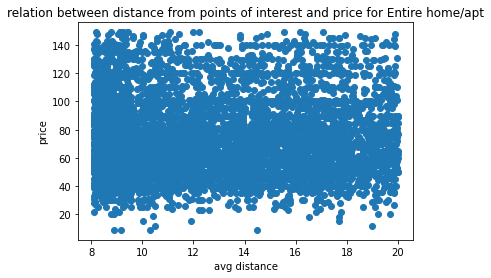

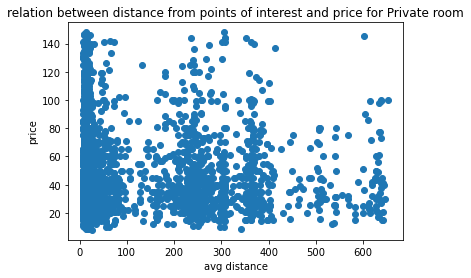

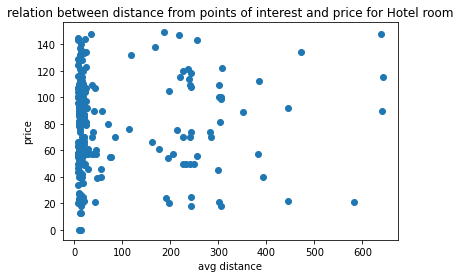

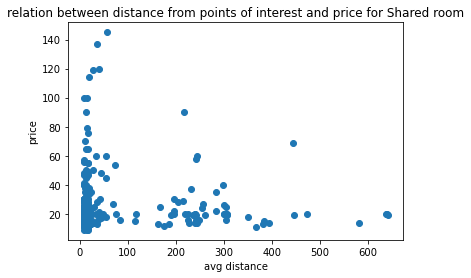

In [508]:
#scatter plots of every sub_dataset representing relation between price and average distance form points of interest
#in some of them we can already see a bit of a correlation between distance from points of interest and price.
plot_gen(df_red_apt[df_red_apt['avg interest points-house distance']<20])
plot_gen(df_red_rooms)
plot_gen(df_red_hotel)
plot_gen(df_red_shared)

### graphs above are showing pretty clearly the absence of a significant correlation between house prices and ther closeness to potentially relevant areas. this means that in the following analyis we'll be able to consider the prices as they are without the need to manipulate them, because there is no evident component (that we can compute with the available data) that is affecting the prices.

In [509]:
#showing current correlation values between average distances and prices, as the graphs above were already suggesting there is no relevant correlation 
#between the two variables
correlations={'correlation for apt' : df_red_apt['price'].corr(df_red_apt['avg interest points-house distance']),
             'correlation for rooms' : df_red_rooms['price'].corr(df_red_rooms['avg interest points-house distance']),
             'correlation for hotel' : df_red_hotel['price'].corr(df_red_hotel['avg interest points-house distance']),
             'correlation for shared rooms' : df_red_shared['price'].corr(df_red_shared['avg interest points-house distance'])}
correlations

{'correlation for apt': 0.001012911111752711,
 'correlation for rooms': 0.013140814960563863,
 'correlation for hotel': 0.08155006377765509,
 'correlation for shared rooms': -0.06682102237972119}

# Finding the closest metro station to every single house and the distance from it and attaching said information to the correspondent dataset


In [510]:
metro=metro.set_index('NOME')
    

In [511]:
#finds the closest metro station to a given house and computes the distance from it 
def closest_metro_station_finder(metro, houses, j):
    dist_stat=[]
    h_m_dist={}
    for i in range(len(metro)):
            point=metro.geometry[i]
            x=point.y
            y=point.x
            coord_1=(x, y)
            coord_2=(houses.latitude.iloc[j], houses.longitude.iloc[j])
            distance=geopy.distance.distance(coord_1, coord_2).km
            h_m_dist[metro.index[i]]=distance
    h_m_v=list(h_m_dist.values())
    h_m_k=list(h_m_dist.keys())
    closest_st=min(h_m_v)
    ind=h_m_v.index(closest_st)
    station=h_m_k[ind]
    dist_stat.append(closest_st)
    dist_stat.append(station)
    return dist_stat

In [512]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing shared bedrooms only
distances=[]
stations=[] 
for i in range(len(df_red_shared)):
    new_list=closest_metro_station_finder(metro, df_red_shared, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
df_red_shared['closest station']=stations
df_red_shared['distance from closest station']=distances

In [513]:
df_red_shared

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
117,286153,Shared appartment - double room2,1489229,João,Lisboa,Campolide,38.728510,-9.166440,Shared room,20,...,49,2020-09-24,0.41,2,310,0,Registo como alojamento local no turismo de Po...,48.089863,Praça de Espanha,1.208433
448,942510,Underdog Surf House - Male shared room,455096,Daniel (Underdog Surf House),Lourinh,Lourinh e Atalaia,39.264230,-9.331120,Shared room,21,...,3,2020-08-15,0.04,7,365,0,NaN,18.342461,Odivelas,54.007686
480,1026382,Underdog Surf House - Female Dorm,455096,Daniel (Underdog Surf House),Lourinh,Lourinh e Atalaia,39.265490,-9.329130,Shared room,21,...,2,2019-09-03,0.03,7,365,0,NaN,18.321832,Odivelas,54.099717
624,1365083,Mini Hostel in Lisbon. Room for 4 guests,6401752,Anna,Lisboa,Areeiro,38.738620,-9.135470,Shared room,15,...,114,2021-06-06,1.13,3,334,1,57649/AL,16.084885,Alameda,0.230324
634,1380975,Bed in a 10 mixed dorm shared wc,6855202,Lisboa Central Hostel,Lisboa,Santo Antnio,38.723720,-9.146870,Shared room,14,...,49,2021-11-07,0.74,7,357,17,11282/AL,13.245617,Marquês de Pombal,0.328256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18052,52770821,Monthly Rental - Shared Room,122481877,Joana,Cascais,Carcavelos e Parede,38.685010,-9.339320,Shared room,11,...,0,NaN,NaN,12,341,0,18040/AL,367.162084,Reboleira,12.511589
18104,52882627,N&N (quarto 1),307638833,N&N House Hospedagem,Lisboa,Arroios,38.729950,-9.135580,Shared room,19,...,2,2021-10-31,1.28,4,365,2,Exempt,18.580503,Anjos,0.313098
18105,52882736,N&N (quarto 2),307638833,N&N House Hospedagem,Lisboa,Arroios,38.735990,-9.134840,Shared room,19,...,1,2021-10-26,0.67,4,311,1,Exempt,260.236780,Alameda,0.137259
18240,53210258,Modern Space Sintra 30Min of Lisbon airport a...,278247291,Wellington Marcio De,Sintra,Massam e Monte Abrao,38.757530,-9.280750,Shared room,60,...,0,NaN,NaN,1,362,0,Exempt,54.276134,Reboleira,4.977460


In [514]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing entire apartments only
distances=[]
stations=[] 
for i in range(len(df_red_apt)):
    new_list=closest_metro_station_finder(metro, df_red_apt, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
df_red_apt['closest station']=stations
df_red_apt['distance from closest station']=distances

In [515]:
df_red_apt

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
0,6499,Belém 1 Bedroom Historical Apartment,14455,Bruno,Lisboa,Belm,38.697500,-9.197680,Entire home/apt,40,...,32,2021-11-01,0.36,1,315,6,NaN,48.089863,Rato,4.503949
1,25659,Heart of Alfama Lisbon Center - Cœur de l'Alfama,107347,Ellie,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,...,127,2021-11-27,1.37,1,325,14,56539/AL.,18.342461,Santa Apolónia,0.443087
2,29248,Apartamento Alfama com vista para o rio!,125768,Bárbara,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,...,337,2021-12-03,2.53,1,190,13,23535/AL,18.321832,Santa Apolónia,0.548231
3,29396,Alfama Hill - Boutique apartment,126415,Mónica,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,...,299,2021-12-03,2.57,1,302,40,28737/AL,16.084885,Terreiro do Paço,0.605491
5,29915,Modern and Cool Apartment in Lisboa,128890,Sara,Lisboa,Avenidas Novas,38.745710,-9.152640,Entire home/apt,50,...,46,2021-10-20,0.33,1,228,8,85851/AL.,13.245617,Entre Campos,0.417752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18521,53715663,Studio Apt. with Terrace in Historical Bairro ...,3233768,Alex,Lisboa,Misericrdia,38.711931,-9.146540,Entire home/apt,70,...,0,NaN,NaN,1,179,0,88434/AL,34.342977,Baixa Chiado,0.575944
18522,53715760,Zen Nest in the heart of Lisbon,236728213,Carolina,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,...,0,NaN,NaN,1,95,0,Exempt,13.431954,Avenida,0.279969
18523,53717168,NEW! Charming 2 bed w/patio in historical Mour...,186259819,Isabelle,Lisboa,Santa Maria Maior,38.716469,-9.132524,Entire home/apt,75,...,0,NaN,NaN,8,258,0,68987/AL,234.224613,Martim Moniz,0.317380
18525,53723356,Alfama Top Location 2,6604033,Joao,Lisboa,Santa Maria Maior,38.715410,-9.132390,Entire home/apt,55,...,0,NaN,NaN,4,246,0,29524/AL,8.149208,Martim Moniz,0.394306


In [516]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing private rooms only
distances=[]
stations=[] 
for i in range(len(df_red_rooms)):
    new_list=closest_metro_station_finder(metro, df_red_rooms, i)
    distances.append(new_list[0])
    stations.append(new_list[1])
df_red_rooms['closest station']=stations
df_red_rooms['distance from closest station']=distances

In [517]:
df_red_rooms

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
6,33348,Happy Season,144484,Bruno,Lisboa,Lumiar,38.764270,-9.153010,Private room,40,...,2,2011-07-22,0.02,2,0,0,NaN,48.089863,Quinta das Conchas,0.418690
22,97503,Lovely equipped flat in city centre,515924,Joel,Lisboa,Santo Antnio,38.721290,-9.142200,Private room,22,...,43,2021-08-31,0.34,9,105,1,NaN,18.342461,Avenida,0.321536
27,122572,A confortable room in a nice place,614156,Isabel,Lisboa,So Domingos de Benfica,38.756430,-9.177000,Private room,62,...,0,NaN,NaN,1,0,0,NaN,18.321832,Alto dos Moinhos,0.763963
29,125835,Rent quarter,624965,Vanessa,Vila Franca De Xira,Vila Franca de Xira,38.957220,-9.002640,Private room,50,...,0,NaN,NaN,1,365,0,NaN,16.084885,Moscavide,21.994327
31,126646,"Room and balcony in house, overlooking the ""Ta...",628095,Filipe,Lisboa,Penha de Frana,38.729830,-9.131830,Private room,26,...,292,2021-11-22,3.27,3,87,36,Exempt,13.245617,Anjos,0.393669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18500,53624014,QUARTO CENTRAL 3,55746040,Oscar,Lisboa,Arroios,38.720316,-9.138376,Private room,20,...,0,NaN,NaN,4,345,0,55240/AL,366.268661,Martim Moniz,0.361585
18509,53657807,Alojamento Local pequeno almoço e estacionamento,434525149,Miguel,Vila Franca De Xira,Pvoa de Santa Iria e Forte da Casa,38.884990,-9.048350,Private room,55,...,0,NaN,NaN,1,364,0,121369/AL,365.241800,Moscavide,13.070867
18516,53684586,Carcavelos Beach walking distance room,70282462,Fernanda,Oeiras,"Oeiras e S.Julio da Barra, Pao de Arcos e Caxias",38.682760,-9.322510,Private room,35,...,0,NaN,NaN,12,62,0,108227/AL,367.958439,Reboleira,11.537673
18519,53702623,Quarto aeroporto,228781046,Priscila,Loures,Sacavm e Prior Velho,38.791987,-9.122908,Private room,28,...,0,NaN,NaN,5,343,0,Exempt,365.835396,Encarnação,1.974775


In [ ]:
#using function above to find closest metro station and relative distance from every house in the subdataset containing hotel rooms only
distances=[]
stations=[] 
for i in range(len(df_red_hotel)):
    new_list=closest_metro_station_finder(metro, df_red_hotel, i)
    distances.append(new_list[0])
    stations.append(new_list[1]
df_red_hotel['closest station']=stations
df_red_hotel['distance from closest station']=distances

In [428]:
df_red_hotel

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station
713,1617589,Quarto Duplo com vista - Sintra Small Hostel,8595443,Jorge,Sintra,"S.Maria, S.Miguel, S.Martinho, S.Pedro Penaferrim",38.79107,-9.37948,Hotel room,39,...,37,2021-11-01,0.40,2,359,1,29569 SM,48.089863,Reboleira,14.191382
1313,3421077,The Maverick - Deluxe Family Suite,17235600,The Maverick Surfvillas,Lourinh,Lourinh e Atalaia,39.26840,-9.28299,Hotel room,60,...,2,2019-08-22,0.03,11,300,0,8861-2755-7645,18.342461,Odivelas,53.560926
1861,5438762,Superior Double - Shared Bathroom,28212914,HOrigem,Lisboa,Santa Maria Maior,38.71066,-9.13533,Hotel room,65,...,33,2021-11-15,0.41,5,361,2,9076/AL,18.321832,Terreiro do Paço,0.387967
1932,5692624,Standart Room - Shared Bathroom,28212914,HOrigem,Lisboa,Santa Maria Maior,38.71113,-9.13547,Hotel room,60,...,31,2021-11-05,0.38,5,344,2,9076/AL,16.084885,Rossio,0.400680
1933,5694117,Double Room - Shared Bathroom,28212914,HOrigem,Lisboa,Santa Maria Maior,38.70901,-9.13552,Hotel room,58,...,16,2021-11-14,0.20,5,365,2,9076/AL,13.245617,Terreiro do Paço,0.224139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13675,38937144,GOLDEN TRAM 242 - 10 BED FEMALE ROOM / SHARED ...,98490028,Golden Tram 242,Lisboa,Santa Maria Maior,38.71250,-9.13778,Hotel room,18,...,1,2021-10-23,0.63,13,365,1,56644/AL,243.278345,Rossio,0.187466
13676,38937211,GOLDEN TRAM 242 - 10 BED MALE ROOM / SHARED ROOM,98490028,Golden Tram 242,Lisboa,Santa Maria Maior,38.71252,-9.13779,Hotel room,18,...,1,2021-11-01,0.77,13,363,1,56644/AL,305.810036,Rossio,0.185194
13677,38937213,GOLDEN TRAM 242 - 4 BED MALE ROOM / SHARED ROOM,98490028,Golden Tram 242,Lisboa,Santa Maria Maior,38.71285,-9.13858,Hotel room,22,...,2,2021-10-10,0.08,13,357,1,56644/AL,445.829523,Rossio,0.158820
14706,42431456,Hotel do Chiado,308682213,Hotel Do Chiado,Lisboa,Santa Maria Maior,38.71071,-9.13949,Hotel room,0,...,0,NaN,NaN,1,0,0,NaN,9.120488,Baixa Chiado,0.059521


In [574]:
df_apt=df_red_apt #for convenience i'm reassinging the Entire Apartment data set to a new dataframe that's easier to call
df_rooms=df_red_rooms #for convenience i'm reassinging the Private Rooms data set to a new dataframe that's easier to call
df_hotel=df_red_hotel #for convenience i'm reassinging the Hotel Rooms data set to a new dataframe that's easier to call
df_shared=df_red_shared #for convenience i'm reassinging the Shared rooms Apartment data set to a new dataframe that's easier to call

## attaching the grades of the closest station to the Entire Apartment dataset

In [531]:
#associating grades of the closest station to the main dataset
grades=[]
for i in df_apt['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_apt['correspondent station grade']=grades

In [532]:
df_apt

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,avg interest points-house distance,closest station,distance from closest station,correspondent station grade
0,6499,Belém 1 Bedroom Historical Apartment,14455,Bruno,Lisboa,Belm,38.697500,-9.197680,Entire home/apt,40,...,2021-11-01,0.36,1,315,6,NaN,48.089863,Rato,4.503949,1.022765
1,25659,Heart of Alfama Lisbon Center - Cœur de l'Alfama,107347,Ellie,Lisboa,Santa Maria Maior,38.712410,-9.127060,Entire home/apt,50,...,2021-11-27,1.37,1,325,14,56539/AL.,18.342461,Santa Apolónia,0.443087,1.000602
2,29248,Apartamento Alfama com vista para o rio!,125768,Bárbara,Lisboa,Santa Maria Maior,38.710820,-9.127190,Entire home/apt,60,...,2021-12-03,2.53,1,190,13,23535/AL,18.321832,Santa Apolónia,0.548231,1.000602
3,29396,Alfama Hill - Boutique apartment,126415,Mónica,Lisboa,Santa Maria Maior,38.711560,-9.129870,Entire home/apt,60,...,2021-12-03,2.57,1,302,40,28737/AL,16.084885,Terreiro do Paço,0.605491,2.205083
5,29915,Modern and Cool Apartment in Lisboa,128890,Sara,Lisboa,Avenidas Novas,38.745710,-9.152640,Entire home/apt,50,...,2021-10-20,0.33,1,228,8,85851/AL.,13.245617,Entre Campos,0.417752,3.896096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18521,53715663,Studio Apt. with Terrace in Historical Bairro ...,3233768,Alex,Lisboa,Misericrdia,38.711931,-9.146540,Entire home/apt,70,...,NaN,NaN,1,179,0,88434/AL,34.342977,Baixa Chiado,0.575944,4.852462
18522,53715760,Zen Nest in the heart of Lisbon,236728213,Carolina,Lisboa,Santo Antnio,38.721587,-9.143302,Entire home/apt,40,...,NaN,NaN,1,95,0,Exempt,13.431954,Avenida,0.279969,2.736085
18523,53717168,NEW! Charming 2 bed w/patio in historical Mour...,186259819,Isabelle,Lisboa,Santa Maria Maior,38.716469,-9.132524,Entire home/apt,75,...,NaN,NaN,8,258,0,68987/AL,234.224613,Martim Moniz,0.317380,2.465067
18525,53723356,Alfama Top Location 2,6604033,Joao,Lisboa,Santa Maria Maior,38.715410,-9.132390,Entire home/apt,55,...,NaN,NaN,4,246,0,29524/AL,8.149208,Martim Moniz,0.394306,2.465067


## In the cell below we're creating the regressor variable, which is a combination of the inverse of the distance from the closest metro station and the weight assinged to that very station in terms of relevance within the metrostation network!
why considered the inverse of the distance from the closest metro station so that both the component of the regressor would have a "coherent" effect on the price variable. in fact the if left as they are the two components (distance and weight) would "cancel each other" because a higher distance should theoretically have a negative impact on prices while a higher grade of the closest metro station should have a positive effect. By considering the inverse of the distance if the distance from the closest metro station is higher we can assume the two components to contribute in a coherent way on the variation of the regressor

In [575]:
reverse_distance=1/df_apt['distance from closest station']
regressor=(df_apt['correspondent station grade']+reverse_distance)
df_apt['regressor']=regressor

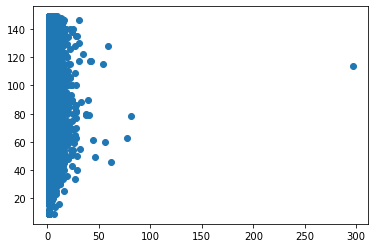

In [576]:
plt.scatter(x=df_apt['regressor'], y= df_apt['price'])

In [577]:
df_apt['price'].corr(df_apt['regressor'])

0.0663919575161974

### In the cell and graph above we can see that there are a few outlier in the regressor variable

In [619]:
#here we're removing those variables that have a regressor value over 10, in order to consider more significat data
df_apt_reducted=df_apt[df_apt['regressor']<10]
df_apt_reducted['price'].corr(df_apt_reducted['regressor'])

0.04395510388967307

In [620]:
#it looks like decreasing the maximum house price considered the correlation values slowly increases
df_apt_reducted=df_apt_reducted[df_apt_reducted['price']<50]
df_apt_reducted['price'].corr(df_apt_reducted['regressor'])

0.10240103832790762

### One (VERY) approximative conslusion we can draw from the fact that the correlation value seems to increase when we consider lower and lower prices could be, that the relevance of the component of price given by the presence of a metro station nearby the house decreases as the overall value of the house increase. 

In [622]:
df_apt_reducted=df_apt_reducted[df_apt_reducted['price']<30]
df_apt_reducted['price'].corr(df_apt_reducted['regressor'])

0.36228072221910795

### the value of correlation even though it remains low, does increase when we remove the outliers

In [623]:
reverse_distance=1/df_apt_reducted['distance from closest station']
regressor=(df_apt_reducted['correspondent station grade']+reverse_distance)
df_apt_reducted['regressor']=regressor

In [629]:
reg = np.polyfit(df_apt_reducted['regressor'], df_apt_reducted['price'], deg =1 )
trend = np.polyval(reg, df_apt_reducted['price'])
reg

array([ 1.04760565, 19.58805742])

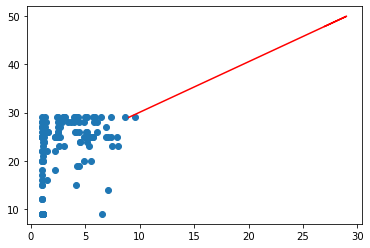

In [625]:
plt.scatter(x=df_apt_reduct['regressor'], y= df_apt_reduct['price'])
plt.plot(df_apt_reduct['price'], trend, 'r')

## attaching the grades of the closest station to the Private Rooms dataset

In [541]:
#associating grades of the closest station to the main dataset
grades=[]
for i in df_rooms['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_rooms['correspondent station grade']=grades

In [542]:
reverse_distance=1/df_rooms['distance from closest station']
regressor=(df_rooms['correspondent station grade']+reverse_distance)
df_rooms['regressor']=regressor

In [605]:
df_rooms_reduct=df_rooms[df_rooms['regressor']<10]
df_rooms_reduct['price'].corr(df_rooms_reduct['regressor'])

-0.149379114546574

In [608]:
reg = np.polyfit(df_rooms['regressor'], df_rooms['price'], deg =1 )
trend = np.polyval(reg, df_rooms['price'])
reg

array([-0.53498683, 47.53247383])

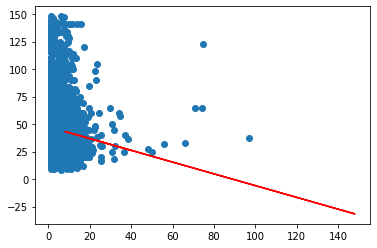

In [609]:
plt.scatter(x=df_rooms['regressor'], y= df_rooms['price'])
plt.plot(df_rooms['price'], trend, 'r')

### we can appreciate that prices for Private Rooms are concetrated in a lower range (obviously)
it makes sense to consider a reducted dataset that does not consider house above a certainv value!

In [610]:
df_rooms_1=df_rooms[df_rooms['price'] < 50]

In [611]:
grades=[]
for i in df_rooms_1['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_rooms_1['correspondent station grade']=grades

In [612]:
reverse_distance=1/df_rooms_1['distance from closest station']
regressor=(df_rooms_1['correspondent station grade']+reverse_distance)
df_rooms_1['regressor']=regressor

In [613]:
reg = np.polyfit(df_rooms_1['regressor'], df_rooms_1['price'], deg =1 )
trend = np.polyval(reg, df_rooms_1['price'])
reg

array([-0.14076214, 31.19307167])

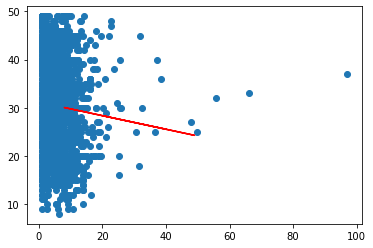

In [614]:
plt.scatter(x=df_rooms_1['regressor'], y= df_rooms_1['price'])
plt.plot(df_rooms_1['price'], trend, 'r')

### we can see that as far as Private Rooms are concerned we find no correlation of any kind between the regressor variable and the house prices.

In [615]:
grades=[]
for i in df_shared['closest station']:
    ind = list(weight['station']).index(i)
    grade=weight['grade'][ind]
    grades.append(grade)
    
df_shared['correspondent station grade']=grades

In [616]:
reverse_distance=1/df_shared['distance from closest station']
regressor=(df_shared['correspondent station grade']+reverse_distance)
df_shared['regressor']=regressor

In [617]:
reg = np.polyfit(df_rooms_1['regressor'], df_rooms_1['price'], deg =1 )
trend = np.polyval(reg, df_rooms_1['price'])
reg

array([-0.14076214, 31.19307167])

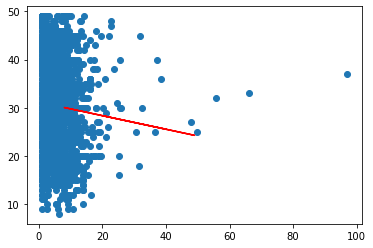

In [618]:
plt.scatter(x=df_rooms_1['regressor'], y= df_rooms_1['price'])
plt.plot(df_rooms_1['price'], trend, 'r')

### We can make similar considerations for she Shared Bedrooms, there is no sign of correlation (at least no sign of positive correlation. We can observe a very small component of negative correlation but it is actually neglecatble in terms of statistic significance.